In [1]:
from pandas_gbq import read_gbq
import matplotlib.pyplot as plt
from tableone import TableOne
from pathlib import Path
import seaborn as sns
import pandas as pd
import numpy as np
import os

In [2]:
PROCEDURES=Path("./procedures")
PROJECT_ID=os.getenv("clinical-entity-extraction") 
# Pass a project-id to a Google Cloud Project.
# Make sure that your google account associated to the google cloud project is the same authorized to access eICU


In [3]:
query=open(PROCEDURES / "transfusion.sql","r").read()
transfusion_df=read_gbq(query,project_id="clinical-entity-extraction")
transfusion_df

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|


,patientunitstayid,itemid,offset,item,value,unit
0,225082,11906874,7899,Volume-Transfuse red blood cells,0.00,ml
1,202313,9875273,13672,Volume-Transfuse red blood cells,25.00,ml
2,216810,14449184,6578,Volume-Transfuse red blood cells,152.00,ml
3,204191,10303177,434,Volume-Transfuse red blood cells,232.00,ml
4,172854,9990001,560,Volume-Transfuse red blood cells,272.00,ml
...,...,...,...,...,...,...
5836,165770,13633978,11796,Volume-Transfuse red blood cells,243.33,ml
5837,148020,13961427,5570,Volume-Transfuse red blood cells,333.80,ml
5838,232142,14110996,34493,Volume-Transfuse red blood cells,289.33,ml
5839,152775,12681747,-2910,Volume-Transfuse red blood cells,361.33,ml


In [4]:
query=open(PROCEDURES / "hgb.sql","r").read()
hgb_df=read_gbq(query,project_id=PROJECT_ID)
hgb_df

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|


,patientunitstayid,itemid,offset,item,value,unit
0,3051144,750593700,4673,Hgb,NaN,g/dL
1,1071138,255186396,-277,Hgb,NaN,g/dL
2,1066174,253980069,-224,Hgb,NaN,g/dL
3,2014956,505792618,-157,Hgb,2.5,g/dL
4,657331,169521936,495,Hgb,4.5,g/dL
...,...,...,...,...,...,...
1298703,711002,166249598,-145,Hgb,16.8,g/dL
1298704,996449,246290059,-549,Hgb,17.8,g/dL
1298705,200319,50419619,-205,Hgb,17.8,g/dL
1298706,1653398,406317309,-99,Hgb,18.8,g/dL


In [5]:
query=open(PROCEDURES / "blood_loss.sql","r").read()
blood_loss_df=read_gbq(query,project_id=PROJECT_ID)
blood_loss_df

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|


,patientunitstayid,itemid,offset,item,value,unit
0,3027972,180592788,895,Blood Loss,0.0,ml
1,3009093,180544331,710,Blood Loss,0.0,ml
2,3015440,181036067,1708,Blood Loss,0.0,ml
3,3019244,180234921,8905,Blood Loss,0.0,ml
4,3004602,180247117,3288,Blood Loss,0.0,ml
...,...,...,...,...,...,...
14565,142417,14638203,15602,Blood Loss,1.0,ml
14566,213556,16109849,10714,Blood Loss,225.0,ml
14567,207035,10603344,-6602,Blood Loss,550.0,ml
14568,210543,13898965,9142,Blood Loss,250.0,ml


In [6]:
ids=transfusion_df['patientunitstayid'].drop_duplicates() # unique ids for all patients to be included
ids=np.array(ids)
# filter any df to only keep patients to be in the study
def filter_ids(df, ids=ids):
    return df[df['patientunitstayid'].isin(ids)]

In [7]:
query=open(PROCEDURES / "apache.sql","r").read()
apache=read_gbq(query,project_id=PROJECT_ID)
apache=filter_ids(apache)
# dropping duplicated patients with multiple apache_score for each apache_version
apache=apache.drop_duplicates(subset='patientunitstayid', keep='first')
apache

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|


,apacheID,patientunitstayid,apache_score,apache_version,pred_mortality,actual_mortality
10,47819,141233,66,IVa,0.035490,ALIVE
18,138144,141266,44,IVa,0.040574,ALIVE
32,42515,141304,67,IV,0.149145,ALIVE
52,122208,141392,35,IVa,0.021379,ALIVE
74,31902,141518,42,IVa,0.026247,ALIVE
...,...,...,...,...,...,...
20548,63741,241726,34,IV,0.037069,ALIVE
20558,26560,241775,103,IV,0.504141,ALIVE
20562,31863,241785,56,IV,0.118066,ALIVE
20564,42498,241787,73,IVa,0.116634,EXPIRED


In [8]:
query=open(PROCEDURES / "demographics.sql","r").read()
demographics=read_gbq(query,project_id=PROJECT_ID)
demographics=filter_ids(demographics)
demographics['age'] = pd.to_numeric(demographics['age'], errors='coerce')
demographics

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|


,patientunitstayid,age,gender,ethnicity,initial_weight
10,141233,81.0,Female,Caucasian,61.7
16,141266,73.0,Male,Caucasian,120.4
23,141304,70.0,Male,Caucasian,NaN
34,141392,78.0,Female,Caucasian,NaN
47,141518,85.0,Female,Caucasian,55.3
...,...,...,...,...,...
14933,241726,75.0,Female,Caucasian,NaN
14938,241775,44.0,Female,Caucasian,45.4
14945,241785,77.0,Female,Caucasian,75.3
14947,241787,61.0,Male,Caucasian,95.5


In [9]:
demographics.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2098 entries, 10 to 14956
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   patientunitstayid  2098 non-null   Int64  
 1   age                2018 non-null   float64
 2   gender             2098 non-null   object 
 3   ethnicity          2098 non-null   object 
 4   initial_weight     1588 non-null   float64
dtypes: Int64(1), float64(2), object(2)
memory usage: 100.4+ KB


In [10]:
demog_columns = demographics.columns
demog_categorical=['gender']
demog_nonnormal=['patientunitstayid', 'age']

demog_table = TableOne(demographics,
                       columns=list(demog_columns),
                       categorical=demog_categorical,
                       nonnormal=demog_nonnormal,
                       groupby='ethnicity')

In [11]:
demog_table

Grouped by ethnicity                                                                                                                                                                                                                                                
                                                      Missing                       Overall                                            African American                         Asian                     Caucasian                      Hispanic               Native American                 Other/Unknown
n                                                          26                            26                            26                           240                            41                          1652                           120                            15                             4
patientunitstayid, median [Q1,Q3]                           0  192690.5 [166067.5,217377.5]  195878.5 [173739.0,210616.8]  193057.5 [163286.0,220422.8]  181038.0 [163580.0,208303.0]  191943.5 [166352.5,216401.0]  195659.0 [170274.0,221130.2]  190696.0 [156271.0,210013.5]  217268.5 [205050.5,228976.8]
age, median [Q1,Q3]                                        80              67.0 [56.0,77.0]              58.0 [54.0,79.0]              59.0 [51.0,69.0]              63.0 [43.2,70.0]              69.0 [60.0,78.0]              52.0 [41.0,63.5]              56.0 [55.5,66.5]              62.0 [53.0,73.5]
gender, n (%)                     Female                                        1017 (48.5)                     13 (50.0)                    128 (53.3)                     20 (48.8)                    792 (47.9)                     60 (50.0)                      3 (20.0)                      1 (25.0)
                                  Male                                          1081 (51.5)                     13 (50.0)                    112 (46.7)                     21 (51.2)                    860 (52.1)                     60 (50.0)                     12 (80.0)                      3 (75.0)
initial_weight, mean (SD)                                 510                   82.4 (29.7)                   79.6 (24.2)                   85.3 (31.3)                   56.1 (11.8)                   83.0 (30.2)                   76.8 (20.0)                   94.5 (17.7)                   61.6 (11.8)

*Testing extracting for one hour before*

In [12]:
hgb_readings_df=pd.DataFrame(columns=['patientunitstayid', 'hgb_before', 'hgb_after', 'before_offset', 'after_offset', 'transfusion_offset'])

In [13]:

# trns_number: transfusion order form transfusion_df for this patient (1st transfusion, 2nd, etc...)
# window_size (minutes): interval to use when looking for offset values 
# x_id: the order of the patientunitstayid in the 'ids' array 

def readings(trns_number, window_size, x_id):
    id=ids[x_id]
    # hgb readings for patient
    hgb_read=hgb_df[hgb_df['patientunitstayid']==id]
    # transfusions for patient
    transfusion=transfusion_df[transfusion_df['patientunitstayid']==id]
    # transfusion_offset=transfusion.offset.unique() # might remove, offsets are unique (check)
    
    hgb_read=hgb_read.sort_values(by=['offset'])
    transfusion=transfusion.sort_values(by=['offset'])
    
    
    # time of transfusion
    transfusion_offset=transfusion.iloc[trns_number, 2]
    
    # interval=[(transfusion_offset-window_size), (transfusion_offset+window_size)]
    
    # time of hgb reading [before, after]
    result = hgb_read[(hgb_read['offset'] >= transfusion_offset - window_size) 
                    & (hgb_read['offset'] <= transfusion_offset + window_size)]
    
    matching_offsets=result['offset'].tolist()
    before_offset = matching_offsets[0] if len(matching_offsets) > 0 else np.nan
    after_offset = matching_offsets[1] if len(matching_offsets) > 1 else np.nan
    
    matching_values = result['value'].tolist()    
    hgb_before = matching_values[0] if len(matching_values) > 0 else np.nan
    hgb_after = matching_values[1] if len(matching_values) > 1 else np.nan
    
    
    
    hgb_readings_df.loc[hgb_readings_df.shape[0]]=[ids[x_id], hgb_before, hgb_after, before_offset, after_offset, transfusion_offset]

In [14]:
# you can try different window sizes to see which will give a more complete chart for hgb_readings_df

hgb_readings_df=pd.DataFrame(columns=['patientunitstayid', 'hgb_before', 'hgb_after', 'before_offset', 'after_offset', 'transfusion_offset'])
# this will extract hgb readings for patients in 'ids' based on the given parametes
for i in range(500):
    readings(0, 500, i)

In [15]:
hgb_readings_df.head(40)

,patientunitstayid,hgb_before,hgb_after,before_offset,after_offset,transfusion_offset
0,225082.0,10.3,8.8,-121.0,150.0,149.0
1,202313.0,9.4,9.0,1272.0,1642.0,1477.0
2,216810.0,6.9,NaN,-67.0,NaN,225.0
3,204191.0,2.7,NaN,-185.0,NaN,164.0
4,172854.0,8.4,7.7,-266.0,49.0,179.0
5,223235.0,NaN,NaN,NaN,NaN,1193.0
6,230150.0,7.5,8.6,-2046.0,-1406.0,-1741.0
7,236004.0,6.0,8.9,4520.0,4912.0,4886.0
8,193890.0,NaN,NaN,NaN,NaN,-39211.0
9,212177.0,7.2,7.5,-106.0,19.0,209.0


In [24]:
# Find the average difference in time between the first two HGB readings for every patient

time_diff=np.array([])
for id in ids:
    # hgb readings for patient
    hgb_read=hgb_df[hgb_df['patientunitstayid']==id]
    hgb_read=hgb_read.sort_values(by=['offset'])

    try:
        time_diff =np.insert(time_diff, 0, hgb_read.iloc[1, 2]-hgb_read.iloc[0, 2])
    except:
        pass

In [25]:
print('avg time diff:', time_diff.mean())
print('avg time std:', time_diff.std())

avg time diff: 1015.1760843269396
avg time std: 7785.874965495244


In [26]:
time_diff.max()

314820.0

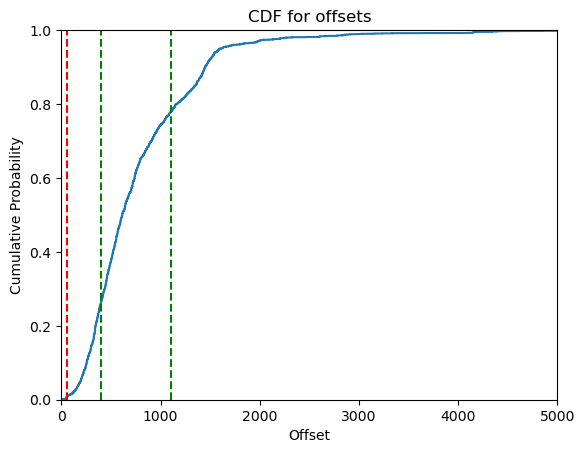

In [27]:
import numpy as np

# the cdf show a steep increase between the green lines, so the majority of hgb reading seperated by 400-1100 mins
# the red line shows distribution of hgb readings with a difference of 60mins, which a low fraction

sns.ecdfplot(time_diff)
plt.xlim(0, 5000)

plt.axvline(60, color='red', linestyle='--')
plt.axvline(400, color='green', linestyle='--')
plt.axvline(1100, color='green', linestyle='--')
plt.xlabel('Offset')
plt.ylabel('Cumulative Probability')
plt.title('CDF for offsets')
plt.show()

In [20]:
# This functions plots a graph with two lines. For every transfusion taken, a point is plotted to show Hgb value at the latest time before
# the infusion, and the earliest time after the transfusion

# this might be used instead if looking at a fixed window size

ids=transfusion_df['patientunitstayid']
def graph_hb(x):
    id=ids[x]
    # hgb readings for patient
    hgb_read=hgb_df[hgb_df['patientunitstayid']==id]
    # transfusions for patient
    transfusion=transfusion_df[transfusion_df['patientunitstayid']==id]
    transfusion_offset=transfusion.offset.unique()
    
    start = transfusion_offset.min()
    stop = transfusion_offset.max()
    
    num_values = int(hgb_read.shape[0] * 0.6)
    inc = np.linspace(start, stop, num=num_values + 2)[1:-1]
    
    transfusion=transfusion.sort_values(by=['offset'])
    # bl_patietransfusionnt
    hgb_read=hgb_read.sort_values(by=['offset'])
    hgb_read['offset'] = hgb_read['offset'].astype(float)
    hgb_read
    
    hb_before = []
    hb_after = []
    
    def find_nearest_indices(times, time):
      before_idx = np.searchsorted(times, time, side='right') - 1
      after_idx = before_idx + 1
      return before_idx, after_idx
    
    for transfusion_time in inc:
      before_idx, after_idx = find_nearest_indices(hgb_read['offset'].values, transfusion_time)
    
      if before_idx >= 0:
          hb_before.append(hgb_read.iloc[before_idx]['value'])
      else:
          hb_before.append(np.nan)
    
      if after_idx < len(hgb_read):
          hb_after.append(hgb_read.iloc[after_idx]['value'])
      else:
          hb_after.append(np.nan)
    
    hb_before = np.array(hb_before)
    hb_after = np.array(hb_after)
    
    print("Hemoglobin before transfusion:", hb_before)
    print("Hemoglobin after transfusion:", hb_after)
    
    plt.plot(inc*1/(60*24),hb_before, label='before infusion', marker='o')
    plt.plot(inc*1/(60*24),hb_after, label='after infusion', marker='o')
    plt.xlabel('Transfusion Offset (days)')
    plt.ylabel('Hemoglobin Value (g/dL)')
    m=ids[x]
    plt.title(f'Hemoglobin Value Before/After Blood Infusion; ID:{m}')
    plt.legend()
    plt.show()

Hemoglobin before transfusion: [7.  7.  7.  7.  7.  7.6 7.6 7.6 7.6 7.7]
Hemoglobin after transfusion: [7.6 7.6 7.6 7.6 7.6 7.7 7.7 7.7 7.7 7.8]


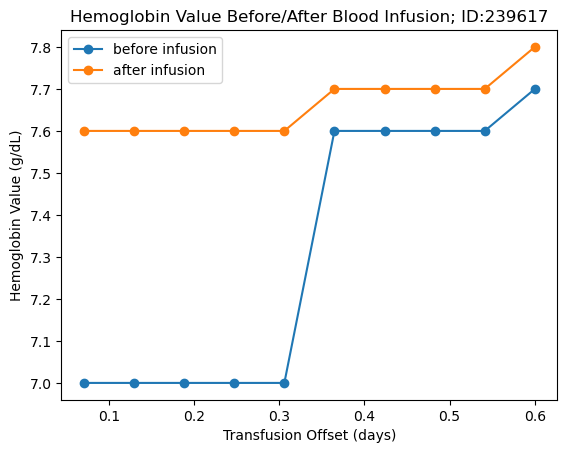

In [21]:
graph_hb(343)